In [2]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.0 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import monai
from monai.data import DataLoader, decollate_batch, CacheDataset
from monai.data import DataLoader, ImageDataset
from sys import platform
import numpy as np
import pandas as pd
import warnings
from monai.networks.nets import DenseNet121
import random
import re
import matplotlib.pyplot as plt
from monai.visualize import GradCAM
from skimage.filters import threshold_otsu
from nilearn.image import resample_img
from nilearn.datasets import load_mni152_template
import nibabel as nib
from nilearn import plotting
from nilearn import datasets


def set_determinism(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_determinism(seed=12)

"""
Create a dictionary {'image': link, 'label': label} specifying the channel (T1w, T2w)
"""


def obtain_channel_data(df, channel, classes):
    
    label_map = {
        'AD': 0,
        'CN': 1,
        'cMCI': 2,
        'ncMCI': 3
    }

    df['labels'] = df['label'].map(label_map)
    df_train = df[df['set'] == 'train']
    df_val = df[df['set'] == 'val']
    df_test = df[df['set'] == 'test']
    
    column = f'{channel}_path'
    
    df_train = df_train[[column, 'labels']].copy()
    df_train.rename(columns={column: 'image'}, inplace=True)
    df_train.rename(columns={'labels': 'label'}, inplace=True)
    df_train['image'] = df_train['image'].str.replace(r'\\', '/', regex=False)

    df_val = df_val[[column, 'labels']].copy()
    df_val.rename(columns={column: 'image'}, inplace=True)
    df_val.rename(columns={'labels': 'label'}, inplace=True)
    df_val['image'] = df_val['image'].str.replace(r'\\', '/', regex=False)

    df_test = df_test[[column, 'labels']].copy()
    df_test.rename(columns={column: 'image'}, inplace=True)
    df_test.rename(columns={'labels': 'label'}, inplace=True)
    df_test['image'] = df_test['image'].str.replace(r'\\', '/', regex=False)
    
    #df_test['image'] = df_test['image'].apply(test_path)

    df_train['label'] = df_train['label'].apply(lambda x: torch.nn.functional.one_hot(torch.as_tensor(x), num_classes=classes).float())
    df_val['label'] = df_val['label'].apply(lambda x: torch.nn.functional.one_hot(torch.as_tensor(x), num_classes=classes).float())
    df_test['label'] = df_test['label'].apply(lambda x: torch.nn.functional.one_hot(torch.as_tensor(x), num_classes=classes).float())
    
    df_train=df_train.reset_index()
    df_val=df_val.reset_index()
    df_test=df_test.reset_index()

    return df_train, df_val, df_test
                
scan_type='T2w' # [T1w, T2w]
task='all' # [all, binary1, binary2, ternary1, ternary2]

classes=4
data=pd.read_csv('/kaggle/input/oasis-final/metadata_updated.csv')  

if task =='binary1':
    data=data[(data['label'] == 'CN') | (data['label'] == 'AD')]
    classes=2
elif task =='ternary1':
    data=data[(data['label'] == 'CN') | (data['label'] == 'AD') | (data['label'] == 'cMCI')]
    classes=3
elif task =='ternary2':
    data=data[(data['label'] == 'CN') | (data['label'] == 'cMCI') | (data['label'] == 'ncMCI')]
    classes=3    
elif task =='binary2':
    data=data[(data['label'] == 'cMCI') | (data['label'] == 'ncMCI')]
    classes=2   
elif task == 'all':
    classes=4

_, _, test_set = obtain_channel_data(data, scan_type, classes)
pin_memory = torch.cuda.is_available()

test_ds = ImageDataset(image_files=test_set['image'], labels=test_set['label'])
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1, pin_memory=pin_memory)

model = DenseNet121(spatial_dims=3, in_channels=1, out_channels=classes).to('cpu')
model_path = '/kaggle/input/19.-multi/pytorch/default/1/19.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval();

/tmp/ipykernel_30/1528909611.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


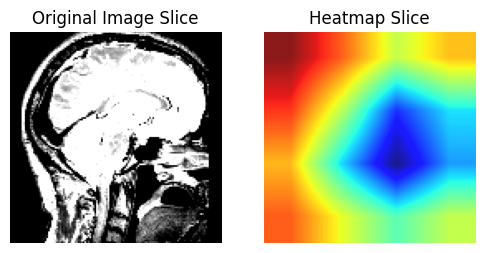

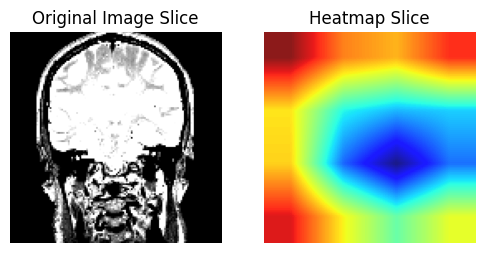

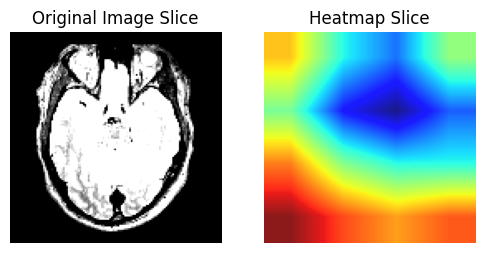

In [ ]:
# Apply GradCAM
model.eval()
cam = GradCAM(nn_module=model, target_layers=["features.denseblock4.denselayer16"]) 
tensor_data = torch.tensor(np.expand_dims(test_ds[86][0], axis=0) , dtype=torch.float32)
result = cam(x=tensor_data)

# Apply transformations on the heatmap
heatmap = result[0]
heatmap = torch.mean(heatmap, dim=0)
heatmap = heatmap.cpu().detach().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
original_image = tensor_data.squeeze().cpu().numpy()
original_image = np.clip(original_image, 0, 1)


def display_slice(original, heatmap, slice_index, axis=0):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    if axis == 0:  # axial
        orig_slice = np.rot90(original[slice_index, :, :])
        heat_slice = np.rot90(heatmap[slice_index, :, :])
    elif axis == 1:  # coronal
        orig_slice = np.rot90(original[:, slice_index, :])
        heat_slice = np.rot90(heatmap[:, slice_index, :])
    elif axis == 2:  # sagittal
        orig_slice = np.rot90(original[:, :, slice_index])
        heat_slice = np.rot90(heatmap[:, :, slice_index])
    ax[0].imshow(orig_slice, cmap='gray')
    ax[0].set_title('Original Image Slice')
    ax[0].axis('off')
    ax[1].imshow(heat_slice, cmap='jet', alpha=0.9)
    ax[1].set_title('Heatmap Slice')
    ax[1].axis('off')
    plt.show()

slice_index = original_image.shape[0] // 2  
display_slice(original_image, heatmap, slice_index, axis=0)
display_slice(original_image, heatmap, slice_index, axis=1)
display_slice(original_image, heatmap, slice_index, axis=2)

In [ ]:
# Create segmentation mask

thresh = threshold_otsu(heatmap)
segmentation_mask = heatmap >= thresh

slice_index = segmentation_mask.shape[0] // 2 
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('Heatmap')
plt.imshow(np.rot90(heatmap[slice_index]), cmap='jet')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Segmentation Mask')
plt.imshow(np.rot90(segmentation_mask[slice_index]), cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
segmentation_mask=segmentation_mask.astype(np.uint8)
seg_mask = nib.Nifti1Image(segmentation_mask, np.eye(4))
mni_template = load_mni152_template()
mni_data = mni_template.get_fdata()

resampled_mask = resample_img(seg_mask, target_affine=mni_template.affine, 
                               target_shape=mni_template.shape, interpolation='linear')

plotting.plot_stat_map(resampled_mask, threshold=0.1, title='Segmentation Mask in MNI Space', 
                        display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True, cmap='plasma')
plt.show()

In [ ]:
atlas = datasets.fetch_atlas_juelich(atlas_name='prob-1mm', data_dir=None, symmetric_split=False, resume=True, verbose=1)
atlas_img = atlas.maps
atlas_labels = atlas.labels

In [9]:
resampled_seg_mask = resample_img(seg_mask, 
                                 target_affine=atlas_img.affine, 
                                 target_shape=atlas_img.shape[:-1], 
                                 interpolation='nearest')
atlas_data = atlas_img.get_fdata()  
seg_data = resampled_seg_mask.get_fdata()

impact_data = []

for idx in range(0,atlas_data.shape[-1]):  
    region_mask = (atlas_data[..., idx] > 0)  
    overlap = np.logical_and(region_mask, seg_data > 0)  

    overlap_percentage = np.sum(overlap) / np.sum(region_mask) * 100 if np.sum(region_mask) > 0 else 0
    seg_percentage = np.sum(overlap) / np.sum(seg_data > 0) * 100 if np.sum(seg_data > 0) > 0 else 0

    impact_data.append({
        'Region': atlas_labels[idx],
        '%_Heatmap': seg_percentage,
        '%_Region': overlap_percentage
    })
impact_df = pd.DataFrame(impact_data)
impact_df = impact_df.sort_values(by='%_Heatmap', ascending=False).head(30)

In [10]:
impact_df

,Region,%_Heatmap,%_Region
26,GM Medial geniculate body,5.521805,18.716088
6,GM Anterior intra-parietal sulcus hIP3,4.600100,35.823935
7,GM Broca's area BA44,4.233244,39.100828
53,WM Acoustic radiation,3.804601,13.823254
54,WM Callosal body,1.248541,17.236115
39,GM Secondary somatosensory cortex / Parietal o...,0.979981,13.718456
60,WM Superior longitudinal fascicle,0.684916,27.722913
55,WM Cingulum,0.523604,2.195061
38,GM Secondary somatosensory cortex / Parietal o...,0.289273,6.503038
35,GM Primary somatosensory cortex BA3a,0.271369,1.620324


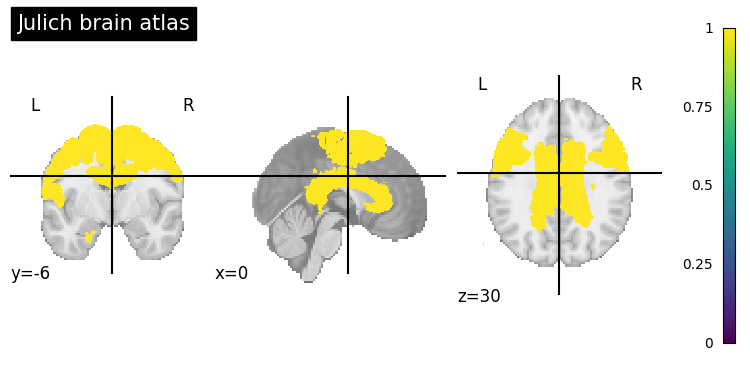

In [13]:
mask = np.zeros(atlas_data.shape)
for idx, row in impact_df.iterrows():
    region_name = row['Region']
    region_idx = atlas_labels.index(region_name)  
    if region_idx > 0:  
        mask[atlas_data[..., region_idx] > 0] = 1  
        
masked_img = nib.Nifti1Image(mask,atlas_img.affine)
resampled_mask = resample_img(masked_img, target_affine=mni_template.affine, 
                               target_shape=mni_template.shape, interpolation='nearest')

if len(resampled_mask.shape) == 4:
    resampled_mask_3d = resampled_mask.slicer[:, :, :, 0]
else:
    resampled_mask_3d = resampled_mask 

plotting.plot_stat_map(resampled_mask_3d, threshold=0, title='Julich brain atlas', 
                        display_mode='ortho', colorbar=True, cmap='viridis')

In [12]:
# include only values of % > 0
impact_df = impact_df[(impact_df['%_Heatmap'] != 0) | (impact_df['%_Region'] != 0)]
impact_df=impact_df.head(5)
visual_heatmaps = impact_df.to_json(orient='records', lines=True) 
labels=data['label'].unique().tolist()

In [41]:
final_json = [
    {
        'Models_used': {
            'Classification_model': 'DenseNet101',
            'Visual_explainability_model': 'GradCAM'
        },
        'Data': {
            "Scan_type": scan_type,
            'Labels': labels
        },
        'Metrics': {
            'ROC_AUC': 0.69,
            'accuracy': 0.42,
            'precision': 0.40,
            'recall': 0.42,
            'f1_score': 0.40
        },
        'Visual_heatmaps': visual_heatmaps
    }
]

In [43]:
import json
with open("json_report_t2w_all_first5.json", "w") as json_file:
    json.dump(final_json, json_file, indent=4)